**E-HEALTH - LABORATORY 1**

**DOWNLOAD THE DATASET**

In this laboratory, we will use the data that are available at link https://drive.google.com/file/d/1EjvX_YGIbMe9I9zaf56dl758pG29FJET/view?usp=sharing

We download the folder and add the data to the COLAB Notebook.

In [ ]:
%pip install googledrivedownloader

from googledrivedownloader import download_file_from_google_drive
import zipfile

download_file_from_google_drive(file_id='1EjvX_YGIbMe9I9zaf56dl758pG29FJET',
                                dest_path='./ehealth_lab_1.zip',
                                unzip=False,
                                overwrite=True)

with zipfile.ZipFile("./ehealth_lab_1.zip","r") as zip_ref:
    zip_ref.extractall("./ehealth_lab_1")

path_to_dataset_folder = "./ehealth_lab_1/"

We install and import `mne` and other useful Python packages.

In [ ]:
%pip install mne
import mne
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 32.3 MB/s eta 0:00:00


Today, we will work with a dataset of ECG signals from PhysioNet, a free-available repository of medical data, managed by MIT.

The full dataset can be found at https://physionet.org/content/simultaneous-measurements/1.0.2/.

We consider a subset of the original dataset. The data are contained in the folder "path_to_dataset_folder".

In [ ]:
os.listdir(path_to_dataset_folder)

['x003_FAROS.edf',
 'x001_FAROS.edf',
 'x004_FAROS.edf',
 'x002_FAROS.edf',
 'x005_FAROS.edf']

We load one of the file that are in the folder.

In [ ]:
raw_data = mne.io.read_raw_edf(path_to_dataset_folder + 'x005_FAROS.edf')

Extracting EDF parameters from /content/ehealth_lab_1/x005_FAROS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


We save some useful variables associated with the data.

In [ ]:
sampling_frequency = int(raw_data.info['sfreq']) # Sampling frequency
sampling_period = 1 / raw_data.info['sfreq'] # Sampling period
channel_names = raw_data.info['ch_names'] # List of channel names

We display the channel names to indentify the channel associated with the ECG recording.

In [ ]:
raw_data.info['ch_names']  # The name of the channels

['ECG',
 'Accelerometer_X',
 'Accelerometer_Y',
 'Accelerometer_Z',
 'Marker',
 'HRV',
 'DEV_Temperature']

We select a portion of the ECG signal lasting 2**12 samples.

In [ ]:
sample_size = 2 ** 12 # Set a power of two as sample size
ecg_signal = raw_data.get_data()[0][:sample_size] * 1000  # The ECG is associated with the first channel, 1000 for mv conversion
ecg_signal_domain = raw_data.times[:sample_size]  # The domain of the ECG signal

We plot the ECG signal.

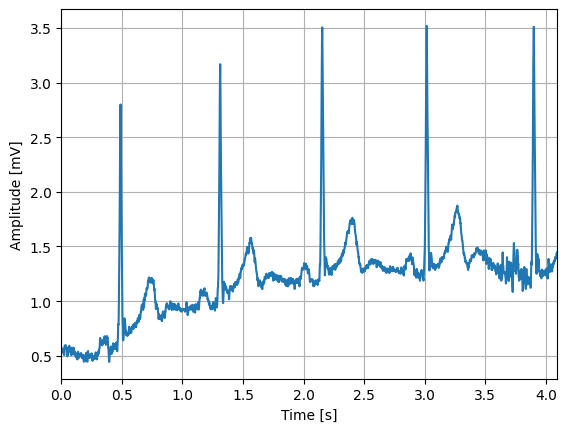

In [ ]:
plt.plot(ecg_signal_domain, ecg_signal)
plt.grid()
plt.xlim([ecg_signal_domain[0], ecg_signal_domain[-1]])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.show()
# the drop in the signal could be noise because of the respiratory

**DYADIC WAVELET TRANFORM**

We consider the so-called Mexican hat as the mother wavelet.

In [ ]:
def mexican_hat(x: float, mu: float = 0, sigma: float = 0.01):
    return 2 / (np.sqrt(3 * sigma) * np.pi**0.25) * (1 - x**2 / sigma**2) * np.exp(-x**2 / (2 * sigma**2) )

We plot the mother wavelet in a range centered in 0.

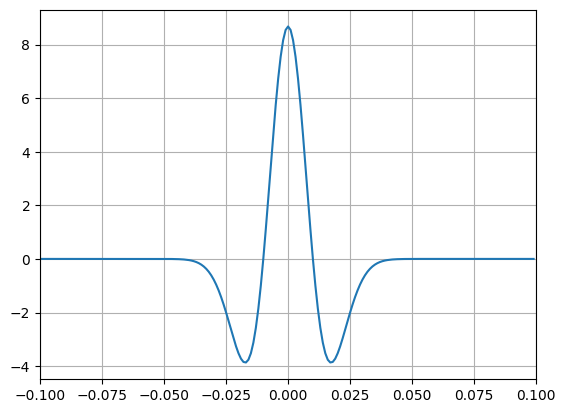

In [ ]:
mother_domain = np.linspace(-1/10, 1/10, num=int(sampling_frequency * 2 / 10), endpoint=False)
mother_wavelet = mexican_hat(mother_domain)
plt.plot(mother_domain, mother_wavelet)
plt.xlim([-1/10, 1/10])
plt.grid()
plt.show()

We define a family of dyadic wavelet atoms by scaling and shifting the mother wavelet by 2^j and m*2^j.

In [ ]:
def get_dyadic_wavelet_atom(mother_domain: np.ndarray,
                            mother_wavelet: np.ndarray,
                            j: int,
                            m: int,
                            sampling_period: float):

  atom_scale = 2 ** j  # The scale (the parameter s in the slide set)
  atom_shift = m * (2 ** j)  # The time shift

  # These are the values of the wavelet atom

  atom_wavelet = np.interp(np.arange(len(mother_wavelet) * atom_scale) / atom_scale, np.arange(len(mother_wavelet)), mother_wavelet) / np.sqrt(atom_scale)

  # This is the time domain of the wavelet atom

  atom_domain = atom_shift * sampling_period + np.linspace(mother_domain[0] * atom_scale, (mother_domain[-1] + sampling_period) * atom_scale, endpoint=False, num = len(mother_domain) * atom_scale)

  return atom_domain, atom_wavelet

We plot a sequence of wavelet atoms.

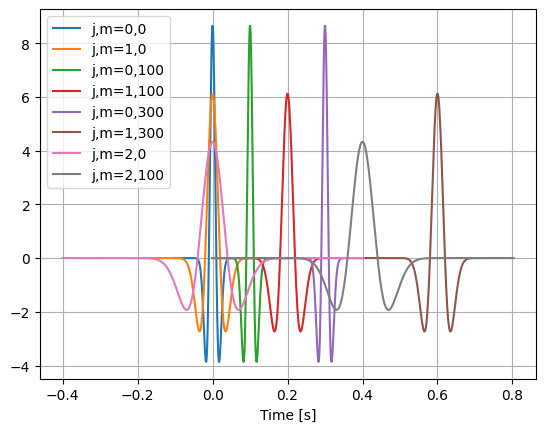

In [ ]:
j_values = [0, 1, 0, 1, 0, 1, 2, 2]   # Scale, enlarge by minimizing (higher pick but smaller support)
m_values = [0, 0, 100, 100, 300, 300, 0, 100]   # Time Shift

# The time domain of the mother wavelet

mother_domain = np.linspace(-1/10, 1/10, num= int(sampling_frequency * 2 / 10))

# The values of the mother wavelet

mother_wavelet = mexican_hat(mother_domain)

for j, m in zip(j_values, m_values):

  # The atom associated with scale j and shift m

  atom_domain, atom_wavelet = get_dyadic_wavelet_atom(mother_domain, mother_wavelet, j, m, sampling_period)

  plt.plot(atom_domain, atom_wavelet, label = 'j,m=' + str(j) + ',' + str(m))

plt.xlabel('Time [s]')

plt.legend(loc="best")

plt.grid()
plt.show()

We define an ad hoc method for plotting the wavelet coefficients.

In [ ]:
def plot_wavelet_coefficient(wavelet_coefficient: np.ndarray,
                             j_values: np.ndarray,
                             m_values: np.ndarray,
                             label='Wavelet coefficient'):

  fig, ax = plt.subplots()

  cax = ax.imshow(wavelet_coefficient,
                  cmap='viridis',
                  aspect='auto',
                  vmin=np.percentile(wavelet_coefficient, 5),
                  vmax=np.percentile(wavelet_coefficient, 95))

  cbar = fig.colorbar(cax, label=label)

  ytick_num = np.min((10, len(j_values)))
  xtick_num = 10

  ytick_size = int(len(j_values) / ytick_num)
  yticks = [int(np.floor(ytick_size / 2)) + i * ytick_size for i in range(ytick_num)]
  ytick_labels = [j_values[int(np.floor(ytick_size / 2)) + i * ytick_size] for i in range(ytick_num)]

  xtick_size = int(len(m_values) / xtick_num)
  xticks = [int(np.floor(xtick_size / 2)) + i * xtick_size for i in range(xtick_num)]
  xtick_labels = [m_values[int(np.floor(xtick_size / 2)) + i * xtick_size] for i in range(xtick_num)]

  plt.xticks(xticks, xtick_labels)
  plt.yticks(yticks, ytick_labels)

  plt.ylabel('j')
  plt.xlabel('m')

  plt.tight_layout()

We compute the wavelet transform of the signal for different scales and shift periods, i.e., different combinations of j and m.

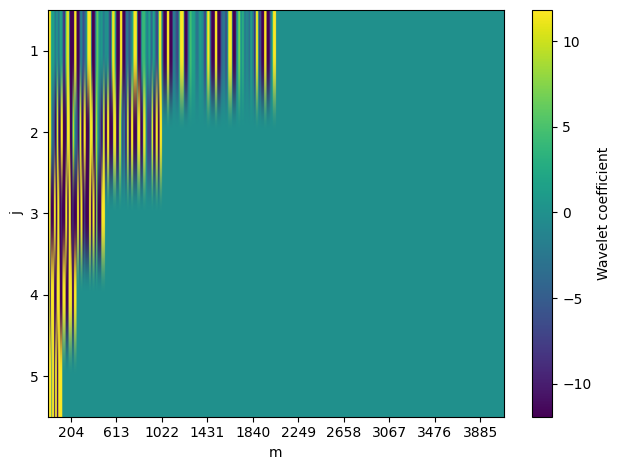

In [ ]:
# The time domain of the mother wavelt

mother_domain = np.linspace(-1/10, 1/10, num = int(sampling_frequency * 2 / 10), endpoint=False)

# The values of the mother wavelet

mother_wavelet = mexican_hat(mother_domain)

j_values = np.arange(1, 6)  # Scale values

m_values = np.arange(sample_size)  # Time shift values

wavelet_coefficients = np.zeros((len(j_values), len(m_values)))  # Matrix where to save the wavelet coefficient

for j_index, j in enumerate(j_values):

  for m_index, m in enumerate(np.arange(int(sample_size / (2**j)))):

    # The atom associated with scale 2 ** j and time shift m * 2 ** j

    atom_domain, atom_wavelet = get_dyadic_wavelet_atom(mother_domain, mother_wavelet, j, m, sampling_period)  # Get the wavelet function associated with (j,m)

    if atom_domain[0] > 0:

      # We fill with zeros the portion of the signal domain that is not covered by the wavelet

      atom_wavelet = np.concatenate((np.zeros(int(sampling_frequency * atom_domain[0])), atom_wavelet))

    else:

      # We do not consider the portion of the wavelet domain that is lower than 0

      atom_wavelet = atom_wavelet[int(np.argmin(np.abs(atom_domain))):]

    max_length = np.min((sample_size, len(atom_wavelet)))

    # Compute the wavelet coefficient

    wavelet_coefficient = np.sum(ecg_signal[:max_length] * atom_wavelet[:max_length])

    wavelet_coefficients[j_index, m_index] = wavelet_coefficient

plot_wavelet_coefficient(wavelet_coefficients, j_values, m_values)

plt.show()

## 4096 is divided by 2 because we use j=2^1 and thats why at 1 we dont have values more than 2048 and same for the rest of them.the higher the j, the lower the m. W = N/2^j

Notably, we have considered a dyadic transformation where the time shift between consecutive wavelet atoms depends on the scale. This implies that we obtain a lower number of wavelet coefficients as we increase the scale.

**DYADIC WAVELET DECOMPOSITION**

In the following, we try to decompose and reconstruct the sinusoid signal by a set of coefficients derived from the Haar wavelet.

The Haar tarnsformation defines the following mother wavelet.

In [ ]:
def haar_wavelet(x):
    h = np.zeros(len(x))
    h[:len(x)//2] = 1
    h[len(x)//2:] = -1
    return h

The Haar transformation defines the following scaling function (or father wavelet).

In [ ]:
def haar_scaling_function(x):
    h = np.ones(len(x))
    return h

We plot a sequence of Haar atoms by changing the scale (j) and the time shift (m).

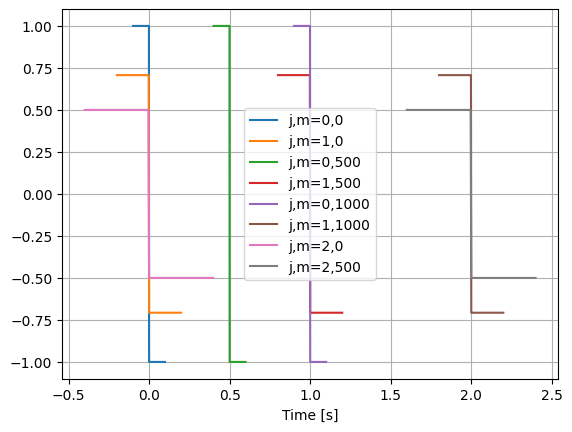

In [ ]:
j_values = [0, 1, 0, 1, 0, 1, 2, 2]
m_values = [0, 0, 500, 500, 1000, 1000, 0, 500]

# The time domain of the mother wavelet

mother_domain = np.linspace(-1/10, 1/10, num=int(sampling_frequency * 2 / 10), endpoint=False)

# The values of the mother wavelet

mother_wavelet = haar_wavelet(mother_domain)

for j, m in zip(j_values, m_values):

  # The wavelet atom associated with scale j and shift m

  atom_domain, atom_wavelet = get_dyadic_wavelet_atom(mother_domain, mother_wavelet, j, m, sampling_period)

  plt.plot(atom_domain, atom_wavelet, label="j,m="+str(j) + ',' + str(m))

plt.xlabel('Time [s]')

plt.legend(loc="best")

plt.grid()
plt.show()

We plot a sequence of Haar scaling functions by changing the scale (j) and the time shift (m), assuming a sampling period of 0.0001 seconds.

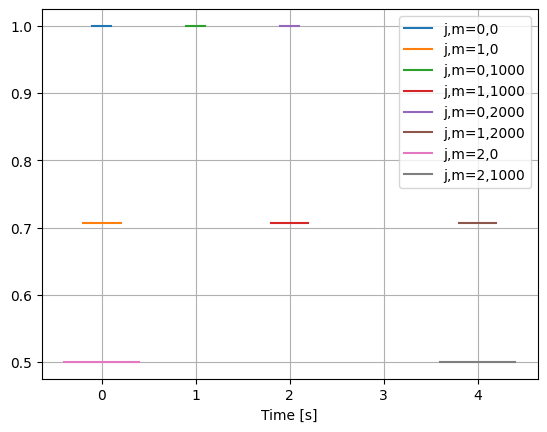

In [ ]:
j_values = [0, 1, 0, 1, 0, 1, 2, 2]
m_values = [0, 0, 1000, 1000, 2000, 2000, 0, 1000]

# The time domain of the father wavelet

father_domain = np.linspace(-1/10, 1/10, num=int(sampling_frequency * 2 / 10), endpoint=False)

# The values of the father wavelet

father_wavelet = haar_scaling_function(mother_domain)

for j, m in zip(j_values, m_values):

  # The wavelet atom associated with scale j and shift m

  atom_domain, atom_wavelet = get_dyadic_wavelet_atom(father_domain, father_wavelet, j, m, sampling_period)

  plt.plot(atom_domain, atom_wavelet, label="j,m="+str(j) + ',' + str(m))

plt.xlabel('Time [s]')

plt.legend(loc="best")

plt.grid()
plt.show()

We define two ad hoc methods to get the dyadic wavelet and scaling functions associated with each combination of scaling and shifting parameters (j,m).

IN PARTICULAR, WE ASSUME THAT THE MOTHER WAVELET HAS A SUPPORT EQUAL TO THE SAMPLING PERIOD!

In [ ]:
def get_haar_dyadic_wavelet(j: int, m: int, sampling_period: float):

  atom_scale = 2 ** j

  atom_shift = m * (2 ** j)

  # The time domain of the wavelet atom

  atom_domain = np.linspace(- 2 ** (j-1), 2 ** (j-1), num=atom_scale, endpoint=False)

  # The values of the wavelet atom

  atom_wavelet = haar_wavelet(atom_domain)

  atom_domain = atom_shift + atom_domain

  return atom_domain * sampling_period, atom_wavelet

In [ ]:
def get_haar_dyadic_scaling_function(j: int, m: int, sampling_period: float):

  atom_scale = 2 ** j

  atom_shift = m * (2 ** j)

  # The time domain of the wavelet atom

  atom_domain = np.linspace(- 2 ** (j-1), 2 ** (j-1), num=atom_scale, endpoint=False)

  # The values of the wavelet atom

  atom_wavelet = haar_scaling_function(atom_domain)

  atom_domain = atom_shift + atom_domain

  return atom_domain * sampling_period, atom_wavelet

We compute the coefficients associated with the wavelet and scaling functions (i.e., the detail and approximation coefficients) for each combination of parameters (j, m).

In [ ]:
def get_detail_coefficients(signal_length: int, j_values: np.ndarray, signal: np.ndarray, sampling_frequency: int, sampling_period: float):

  detail_coefficients = np.zeros((len(j_values), int(signal_length / 2)))  # Matrix where to save the coefficients

  for j_index, j in enumerate(j_values):  # Iterate for all the scale values

    max_m_value = int(signal_length / (2**j))  # Max value that can be taken by m

    for m_index, m in enumerate(np.arange(max_m_value)):  # Iterate for all the shift values

      atom_domain, atom_wavelet = get_haar_dyadic_wavelet(j, m, sampling_period)  # Get the wavelet function associated with (j,m)

      if atom_domain[0] > 0:

        # We fill with zeros the portion of the signal domain that is not covered by the wavelet

        atom_wavelet = np.concatenate((np.zeros(int(sampling_frequency * atom_domain[0])), atom_wavelet))

      else:

        # We do not consider the portion of the wavelet domain that is lower than 0

        atom_wavelet = atom_wavelet[int(np.argmin(np.abs(atom_domain))):]
        atom_domain = atom_domain[int(np.argmin(np.abs(atom_domain))):]

      max_length = np.min((signal_length, len(atom_wavelet)))

      # We compute the wavelet coefficient

      wavelet_coefficient = np.sum(signal[:max_length] * atom_wavelet[:max_length])

      detail_coefficients[j_index, m_index] = wavelet_coefficient

  return detail_coefficients

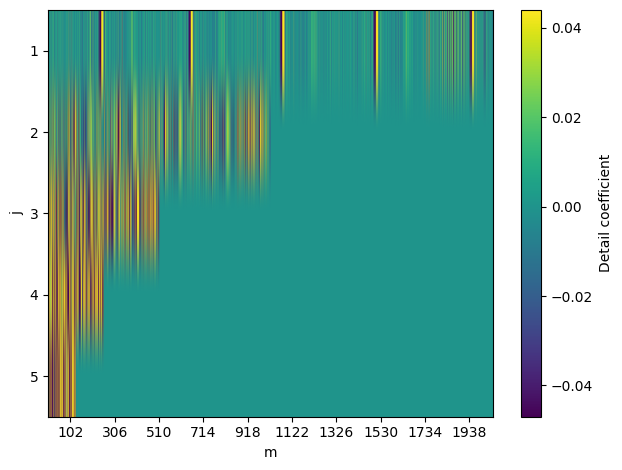

In [ ]:
j_values = np.arange(1, 6) # The j values must be within 1 and log(N)

detail_coefficients = get_detail_coefficients(sample_size, j_values, ecg_signal, sampling_frequency, sampling_period)

plot_wavelet_coefficient(detail_coefficients, j_values, np.arange(int(sample_size / 2)), label='Detail coefficient')

plt.show()

## We can detect QRS the sudden increaments by looking at the very low scale (high freq, j=1)
## in mexican we were using a larger support so thats why we couldnt detect the QRS very good but here by going to lower support and detect

In [ ]:
def get_approx_coefficients(signal_length: int, j_values: np.ndarray, signal: np.ndarray, sampling_frequency: int, sampling_period: float):

  approx_coefficients = np.zeros((len(j_values), int(signal_length / 2)))  # Matrix where to save the coefficients

  for j_index, j in enumerate(j_values):  # Iterate for all the scale values

    max_m_value = int(signal_length / (2**j))  # Max value that can be taken by m

    for m_index, m in enumerate(np.arange(max_m_value)):  # Iterate for all the shift values

      atom_domain, atom_scaling_function = get_haar_dyadic_scaling_function(j, m, sampling_period)  # Get the scaling function associated with (j,m)

      if atom_domain[0] > 0:

        # We fill with zeros the portion of the signal domain that is not covered by the wavelet

        atom_scaling_function = np.concatenate((np.zeros(int(sampling_frequency * atom_domain[0])), atom_scaling_function))

      else:

        # We do not consider the portion of the wavelet domain that is lower than 0

        atom_scaling_function = atom_scaling_function[int(np.argmin(np.abs(atom_domain))):]
        atom_domain = atom_domain[int(np.argmin(np.abs(atom_domain))):]

      max_length = np.min((signal_length, len(atom_scaling_function)))

      # We compute the wavelet coefficient

      wavelet_coefficient = np.sum(signal[:max_length] * atom_scaling_function[:max_length])

      approx_coefficients[j_index, m_index] = wavelet_coefficient

  return approx_coefficients

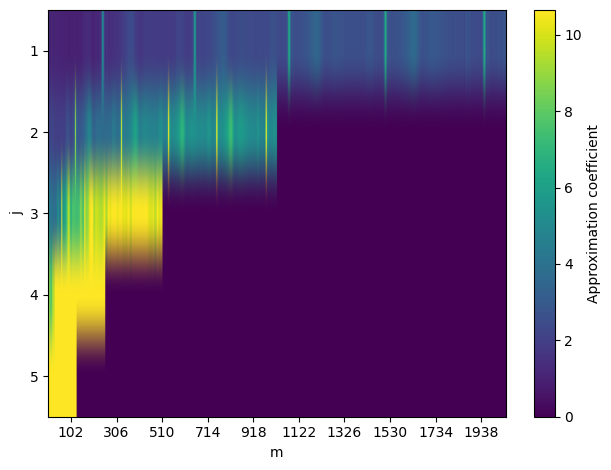

In [ ]:
approx_coefficients = get_approx_coefficients(sample_size, j_values, ecg_signal, sampling_frequency, sampling_period)

plot_wavelet_coefficient(approx_coefficients, j_values, np.arange(int(sample_size / 2)), label='Approximation coefficient')

plt.show()

If we set the scale to j=1 and the signal length is N, we obtain N/2 detail coefficients (via the mother wavelet) and N/2 approximation coefficient (via the father wavelet).

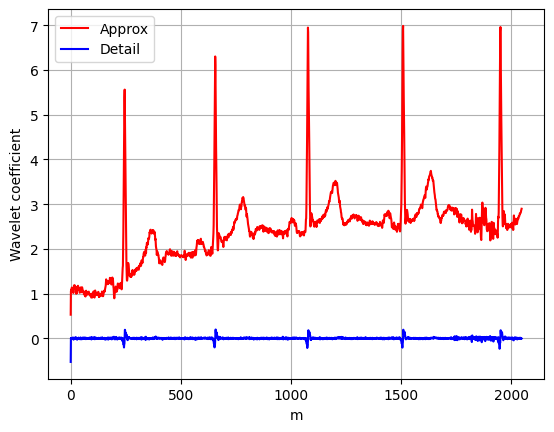

In [ ]:
target_j = 1
target_j_index = np.argwhere(j_values == target_j)[0][0]

plt.plot(np.arange(int(sample_size / (2**target_j))), approx_coefficients[target_j_index][:int(sample_size / (2**target_j))], c='r', label='Approx', alpha=1.0)
plt.plot(np.arange(int(sample_size / (2**target_j))), detail_coefficients[target_j_index][:int(sample_size / (2**target_j))], c='b', label='Detail', alpha=1.0)
plt.grid()
plt.xlabel('m')
plt.ylabel('Wavelet coefficient')
plt.legend()
plt.show()

If we set the scale to j=3 and the signal length is N, we obtain N/8 detail coefficients (obtained via the mother wavelet) and N/8 approximation coefficient (obtained via the father wavelet).

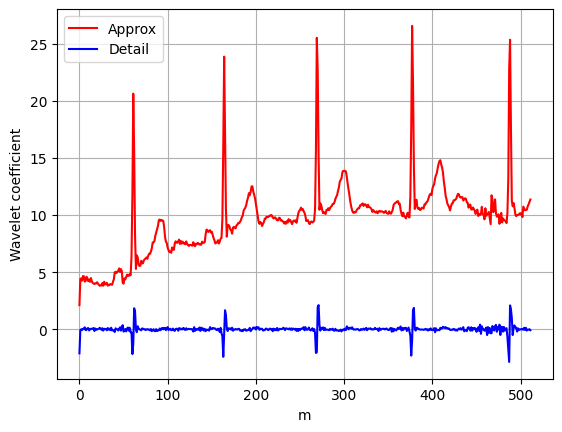

In [ ]:
target_j = 3
target_j_index = np.argwhere(j_values == target_j)[0][0]

plt.plot(np.arange(int(sample_size / (2**target_j))), approx_coefficients[target_j_index][:int(sample_size / (2**target_j))], c='r', label='Approx', alpha=1.0)
plt.plot(np.arange(int(sample_size / (2**target_j))), detail_coefficients[target_j_index][:int(sample_size / (2**target_j))], c='b', label='Detail', alpha=1.0)
plt.grid()
plt.xlabel('m')
plt.ylabel('Wavelet coefficient')
plt.legend()
plt.show()

**We** define a method to reconstruct the signal from the coefficients associated with scale j=1.

In [ ]:
def get_reconstructed_signal_v0(signal_length: int,
                                detail_coefficients: np.ndarray,
                                approx_coefficients: np.ndarray,
                                sampling_frequency: int,
                                sampling_period: float):

  reconstructed_signal = np.zeros(signal_length)

  coefficient_masks = np.zeros(int(signal_length / 2))  # Variable to monitor the number of wavelet coefficients used for the reconstruction

  m_values = np.arange(int(signal_length / 2))  # Time shifts associated with scale j = 1

  for sample_index in range(signal_length):

    m = np.floor((sample_index - 2 ** (0)) / 2) + 1  # Select the time shift associated with the sample

    atom_domain, atom_wavelet = get_haar_dyadic_wavelet(1, m, sampling_period)  # Get the wavelet function

    _, atom_scaling_function = get_haar_dyadic_scaling_function(1, m, sampling_period)  # Get the scaling function

    if atom_domain[0] > 0:

      # We fill with zeros the portion of the signal domain that is not covered by the wavelet

      atom_wavelet = np.concatenate((np.zeros(int(round(sampling_frequency * atom_domain[0]))), atom_wavelet))
      atom_scaling_function = np.concatenate((np.zeros(int(round(sampling_frequency * atom_domain[0]))), atom_scaling_function))

    else:

      # We do not consider the portion of the wavelet domain that is lower than 0

      atom_wavelet = atom_wavelet[int(np.argmin(np.abs(atom_domain))):]
      atom_scaling_function = atom_scaling_function[int(np.argmin(np.abs(atom_domain))):]
      atom_domain = atom_domain[int(np.argmin(np.abs(atom_domain))):]

    if m in m_values:

      m_index = np.argwhere(m_values == m)

      coefficient_masks[m_index] = 2  # 1 detail and 1 approximation

      # We combine the detail and the approximation coefficients, weighted by the wavelet and scaling functions, to reconstruct the signal

      reconstructed_signal[sample_index] += detail_coefficients[m_index] * atom_wavelet[sample_index] / 2

      reconstructed_signal[sample_index] += approx_coefficients[m_index] * atom_scaling_function[sample_index] / 2

  # We observe that np.sum(coefficient_masks) is the total number of coefficients used
  # and, thus, represents the size of the reconstructed signal

  return reconstructed_signal, np.sum(coefficient_masks)

We reconstruct the signal from the N/2 detail coefficients and the N/2 approximation coefficients associated with scale j=1.

In [ ]:
# We observe that detail_coefficients[0] and approx_coefficients[0] are the wavelet and approximation coefficients associated with scale j = 1

reconstructed_signal, reconstruction_size = get_reconstructed_signal_v0(sample_size,
                                                                        detail_coefficients[0],
                                                                        approx_coefficients[0],
                                                                        sampling_frequency,
                                                                        sampling_period)

<ipython-input-31-f56075189b42>:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reconstructed_signal[sample_index] += detail_coefficients[m_index] * atom_wavelet[sample_index] / 2
<ipython-input-31-f56075189b42>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reconstructed_signal[sample_index] += approx_coefficients[m_index] * atom_scaling_function[sample_index] / 2


We plot the reconstructed signal.

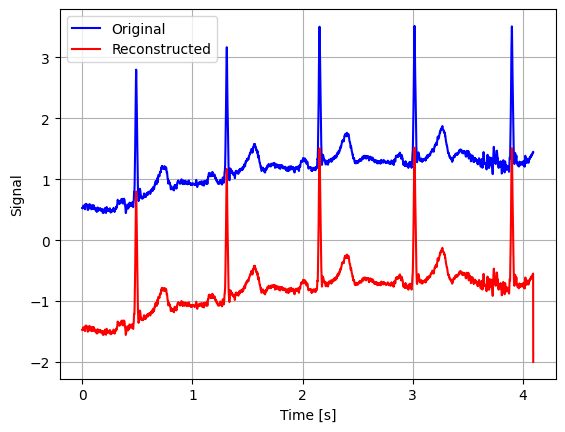

In [ ]:
plt.plot(ecg_signal_domain, ecg_signal, c='b', label='Original')
plt.plot(ecg_signal_domain, reconstructed_signal-2, c='r', label='Reconstructed')
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.legend()
plt.show()

We compute the Root Mean Squared Error (RMSE) and the compression ratio (CR) to evaluate the reconstruction performance.

In [ ]:
rmse = np.sqrt(np.mean(np.abs(reconstructed_signal - ecg_signal) ** 2))

print('RMSE:', rmse)

cr = reconstruction_size / sample_size

print('Compression Ratio (CR):', cr)

# cr is 1 becuase we have N/2 for detail and N/2 for approximation


RMSE: 0.02264244191294857
Compression Ratio (CR): 1.0


We define a method to reconstruct the signal from a different combination of wavelet coefficients.

In [ ]:
def get_reconstructed_signal_v1(signal_length: int,
                                max_j: int,
                                detail_coefficients: np.ndarray,
                                approx_coefficients: np.ndarray,
                                sampling_frequency: int,
                                sampling_period: float):

  reconstructed_signal = np.zeros(signal_length)

  j_values = np.arange(1, max_j+1)  # Consider all the scale from 1 to max_j

  coefficient_masks = np.zeros((len(j_values), 2, int(signal_length / 2)))  # Variable to monitor the number of wavelet coefficients used for the reconstruction

  for sample_index in range(signal_length):

    for j_index, j in enumerate(j_values):

      m = np.floor((sample_index - 2 ** (j-1)) / (2**j)) + 1  # Select the time shift associated with the sample

      atom_domain, atom_wavelet = get_haar_dyadic_wavelet(j, m, sampling_period) # Get the wavelet atom associated with (j,m)

      if atom_domain[0] > 0:

        # We fill with zeros the portion of the signal domain that is not covered by the wavelet

        atom_wavelet = np.concatenate((np.zeros(int(round(sampling_frequency * atom_domain[0]))), atom_wavelet))

      else:

        # We do not consider the portion of the wavelet domain that is lower than 0

        atom_wavelet = atom_wavelet[int(np.argmin(np.abs(atom_domain))):]

      m_values = np.arange(int(signal_length / (2**j)))  # Time shifts associated with scale j

      if m in m_values:

        m_index = np.argwhere(m_values == m)

        # We add the detail coefficient, weighted by the wavelet functions, to reconstruct the signal

        reconstructed_signal[sample_index] += detail_coefficients[j_index, m_index] * atom_wavelet[sample_index] / (2 ** j)

        coefficient_masks[j_index, 0, m_index] = 1

    # Only for the max j value

    if m in m_values:

      m_index = np.argwhere(m_values == m)

      atom_domain, atom_scaling_function = get_haar_dyadic_scaling_function(j, m, sampling_period) # Get the scaling function associated with (j,m)

      if atom_domain[0] > 0:

        # We fill with zeros the portion of the signal domain that is not covered by the wavelet

        atom_scaling_function = np.concatenate((np.zeros(int(round(sampling_frequency * atom_domain[0]))), atom_scaling_function))

      else:

        # We do not consider the portion of the wavelet domain that is lower than 0

        atom_scaling_function  = atom_scaling_function[int(np.argmin(np.abs(atom_domain))):]

      # We add the approximation coefficient associated with the maximum scale, weighted by the scaling functions, to reconstruct the signal

      reconstructed_signal[sample_index] += approx_coefficients[j_index, m_index] * atom_scaling_function[sample_index] / (2 ** j)

      coefficient_masks[j_index, 1, m_index] = 1

  # We observe that np.sum(coefficient_masks) is the total number of coefficients used
  # and, thus, represents the size of the reconstructed signal

  return reconstructed_signal, np.sum(coefficient_masks)

We reconstruct the signal from the wavelet coefficient associated with scale j=1,2,3

In [ ]:
max_j = 3

reconstructed_signal, coefficient_number = get_reconstructed_signal_v1(sample_size,
                                                                       max_j,
                                                                       detail_coefficients,
                                                                       approx_coefficients,
                                                                       sampling_frequency,
                                                                       sampling_period)

<ipython-input-31-3a5ecda0a648>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reconstructed_signal[sample_index] += detail_coefficients[j_index, m_index] * atom_wavelet[sample_index] / (2 ** j)
<ipython-input-31-3a5ecda0a648>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reconstructed_signal[sample_index] += approx_coefficients[j_index, m_index] * atom_scaling_function[sample_index] / (2 ** j)


We plot the reconstructed signal.

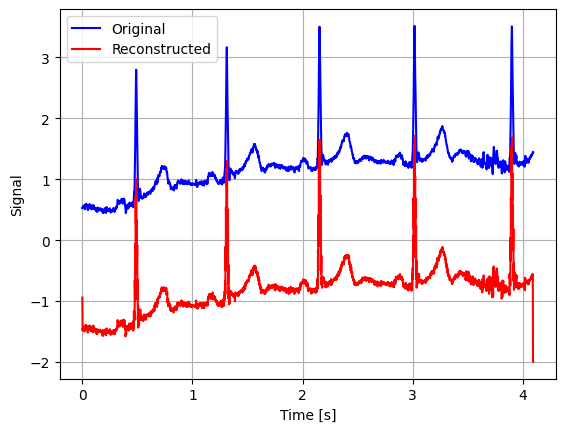

In [ ]:
plt.plot(ecg_signal_domain, ecg_signal, c='b', label='Original')
plt.plot(ecg_signal_domain, reconstructed_signal-2, c='r', label='Reconstructed')
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.legend()
plt.show()

We compute the Root Mean Squared Error (RMSE) and the compression ratio (CR) to evaluate the reconstruction performance.

In [ ]:
rmse = np.sqrt(np.mean(np.abs(reconstructed_signal - ecg_signal) ** 2))

print('RMSE:', rmse)

cr = coefficient_number / sample_size

print('Compression Ratio (CR):', cr)

RMSE: 0.07634668003101257
Compression Ratio (CR): 1.0


We observe that the increase of the maximum scale does not improve the quality of the reconstruction: indeed, both the above methods use the same number of wavelet coefficients for reconstructing the target signal, which is equal to the number of signal samples. If our goal is to compress the signal and save bandwidth, the above approach is meaningless.

To take advantage of the Wavelet Transform (WT), we should reduce the number of information used for the signal reconstruction, prioritizing those coefficients that are more significant.

**YOUR TURN**

In the following, you are asked to define a new method (named `get_reconstructed_signal_v2`) to encode and reconstruct a signal from its wavelet coefficients, using not more than N/4 samples with respect to the initial signal representation. In other words, you are asked to reduce the bandwidth by four times. To test your method, you must consider the ECG signals contained in the laboratory folder.

Notably, a trivial solution is to exploit only N/8 detail and N/8 approximation coefficients associated with a specific scale. A smarter solution may involve the use of multiple coefficients from various scales. To do so, you can modify the method `get_reconstructed_signal_v1`.

**HOW TO COMPLETE THE LAB**

To complete the laboratory, you must test your method in each of the ECG signals included in the laboratory folder, and compute, for each signal, the performance in terms of Root Mean Squared Error (RMSE) and Compression Ratio (CR).

The results, including your method's script and the performance (RMSE and CR) associated with each signal, must be included in a report of a maximum of three pages.

In the laboratory report, you must discuss the reasons behind your methodology and its limitations and benefits in relation with the results.

In [ ]:
def get_reconstructed_signal_v2(signal_length: int,
                                max_j: int,
                                ecg_signal: np.ndarray,
                                detail_coefficients: np.ndarray,
                                approx_coefficients: np.ndarray,
                                sampling_frequency: int,
                                sampling_period: float,
                                num_coefficients_to_keep: int):

    # Initialize reconstruction and residual.
    reconstruction = np.zeros(signal_length)
    residual = ecg_signal.copy()

    candidate_list = []
    # Build candidate dictionary over scales and shifts.
    for j in range(1, max_j + 1):
        m_max = int(signal_length / (2 ** j))
        for m in range(m_max):
            # Compute proper shift: dyadic translation.
            shift_index = m * (2 ** j)
            # Candidate from detail coefficients:
            coeff_val = detail_coefficients[j - 1, m]
            atom_domain, atom_wavelet = get_haar_dyadic_wavelet(j, m, sampling_period)
            # Embed the atom at the correct time index.
            atom_vector = np.zeros(signal_length)
            L = len(atom_wavelet)
            if shift_index + L > signal_length:
                L = signal_length - shift_index  # truncate if needed
            atom_vector[shift_index:shift_index + L] = atom_wavelet[:L]
            candidate_list.append({
                'type': 'detail',
                'j': j,
                'm': m,
                'atom': atom_vector,
                'used': False
            })

            # Candidate from approximation coefficients:
            coeff_val = approx_coefficients[j - 1, m]
            atom_domain, atom_scaling = get_haar_dyadic_scaling_function(j, m, sampling_period)
            atom_vector = np.zeros(signal_length)
            L = len(atom_scaling)
            if shift_index + L > signal_length:
                L = signal_length - shift_index
            atom_vector[shift_index:shift_index + L] = atom_scaling[:L]
            candidate_list.append({
                'type': 'approx',
                'j': j,
                'm': m,
                'atom': atom_vector,
                'used': False
            })

    used_candidates = []

    # Matching Pursuit Loop:
    for iter_idx in range(num_coefficients_to_keep):
        best_ip = 0
        best_candidate = None
        # Search through unused candidates:
        for candidate in candidate_list:
            if candidate['used']:
                continue
            ip = np.dot(residual, candidate['atom'])
            if abs(ip) > abs(best_ip):
                best_ip = ip
                best_candidate = candidate
        if best_candidate is None:
            break  # No candidate found (should not happen)

        # Compute the optimal coefficient:
        norm_sq = np.dot(best_candidate['atom'], best_candidate['atom'])
        if norm_sq == 0:
            coeff = 0.0
        else:
            coeff = best_ip / norm_sq

        # Update reconstruction:
        reconstruction += coeff * best_candidate['atom']
        best_candidate['used'] = True
        used_candidates.append((best_candidate, coeff))

        # Update residual:
        residual = ecg_signal - reconstruction

    coefficient_count = len(used_candidates)
    return reconstruction, coefficient_count

# === Testing the improved version ===
# Set parameters as before:
max_j = 5
num_coefficients_to_keep = int(sample_size / 4)

reconstructed_signal, coefficient_number = get_reconstructed_signal_v6(
    sample_size,
    max_j,
    ecg_signal,
    detail_coefficients,
    approx_coefficients,
    sampling_frequency,
    sampling_period,
    num_coefficients_to_keep
)

rmse = np.sqrt(np.mean((reconstructed_signal - ecg_signal)**2))
cr = coefficient_number / sample_size
print('RMSE with matching pursuit and proper shifting:', rmse)
print('Compression Ratio (CR):', cr)


RMSE with matching pursuit and proper shifting: 0.009070904642600772
Compression Ratio (CR): 0.25


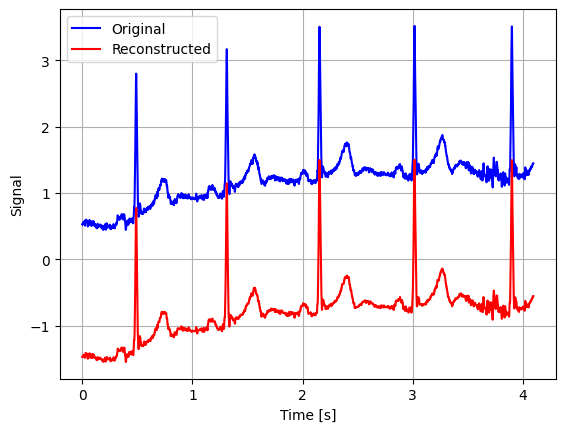

In [ ]:
plt.plot(ecg_signal_domain, ecg_signal, c='b', label='Original')
plt.plot(ecg_signal_domain, reconstructed_signal-2, c='r', label='Reconstructed')
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.legend()
plt.show()